# Predicting Term Deposit Subscriptions Using Neural Networks and Random Forests

- Name: Mohamed ***Saqib*** Shouqi
- IIT ID: 20231934
- RGU ID: 2330955

In [57]:
# Required Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from imblearn.over_sampling import SMOTE

## Load and explore the dataset

In [58]:
# Load dataset

df = pd.read_csv("/content/bank-additional-full.csv", sep=';')

In [59]:
# Initial dataset exploration

print("Dataset Info:")
df.info()

print("\nDataset Shape:", df.shape)

print("\nFirst 5 Rows:\n", df.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   4

In [60]:
# Checking class distribution for target variable

y_distribution = df['y'].value_counts()
print("\nTarget Variable Distribution:\n", y_distribution)


Target Variable Distribution:
 y
no     36548
yes     4640
Name: count, dtype: int64


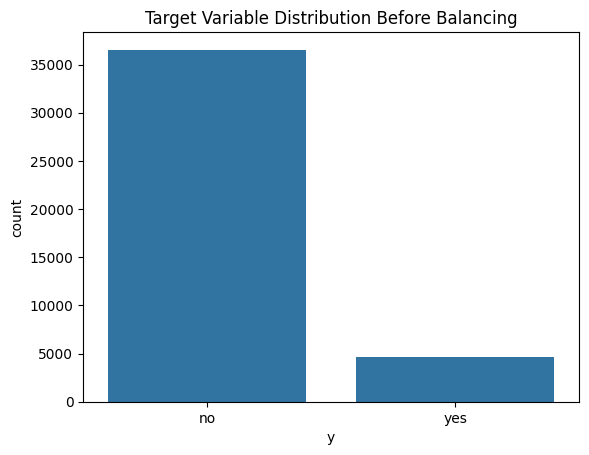

In [61]:
# Plot target variable distribution

sns.countplot(x='y', data=df)
plt.title("Target Variable Distribution Before Balancing")
plt.show()

In [62]:
# Check for missing values

missing_values = df.isnull().sum()
print("\nMissing Values:\n", missing_values[missing_values > 0])


Missing Values:
 Series([], dtype: int64)


In [63]:
# Check for unique values in each column

print("\nUnique Values per Column:\n")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")


Unique Values per Column:

age: 78 unique values
job: 12 unique values
marital: 4 unique values
education: 8 unique values
default: 3 unique values
housing: 3 unique values
loan: 3 unique values
contact: 2 unique values
month: 10 unique values
day_of_week: 5 unique values
duration: 1544 unique values
campaign: 42 unique values
pdays: 27 unique values
previous: 8 unique values
poutcome: 3 unique values
emp.var.rate: 10 unique values
cons.price.idx: 26 unique values
cons.conf.idx: 26 unique values
euribor3m: 316 unique values
nr.employed: 11 unique values
y: 2 unique values


In [64]:
# Exploring categorical features

categorical_features = df.select_dtypes(include=['object']).columns.tolist()
categorical_features.remove('y')  # Exclude target variable

print("\nCategorical Features:", categorical_features)
for col in categorical_features:
    print(f"\nUnique values in {col}: {df[col].unique()}")


Categorical Features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

Unique values in job: ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']

Unique values in marital: ['married' 'single' 'divorced' 'unknown']

Unique values in education: ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']

Unique values in default: ['no' 'unknown' 'yes']

Unique values in housing: ['no' 'yes' 'unknown']

Unique values in loan: ['no' 'yes' 'unknown']

Unique values in contact: ['telephone' 'cellular']

Unique values in month: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']

Unique values in day_of_week: ['mon' 'tue' 'wed' 'thu' 'fri']

Unique values in poutcome: ['nonexistent' 'failure' 'success']


In [65]:
# Exploring numerical features

numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("\nNumerical Features:", numerical_features)
print(df[numerical_features].describe())


Numerical Features: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
               age      duration      campaign         pdays      previous  \
count  41188.00000  41188.000000  41188.000000  41188.000000  41188.000000   
mean      40.02406    258.285010      2.567593    962.475454      0.172963   
std       10.42125    259.279249      2.770014    186.910907      0.494901   
min       17.00000      0.000000      1.000000      0.000000      0.000000   
25%       32.00000    102.000000      1.000000    999.000000      0.000000   
50%       38.00000    180.000000      2.000000    999.000000      0.000000   
75%       47.00000    319.000000      3.000000    999.000000      0.000000   
max       98.00000   4918.000000     56.000000    999.000000      7.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx     euribor3m   nr.employed  
count  41188.000000    41188.000000   41188.000000  41188.00000

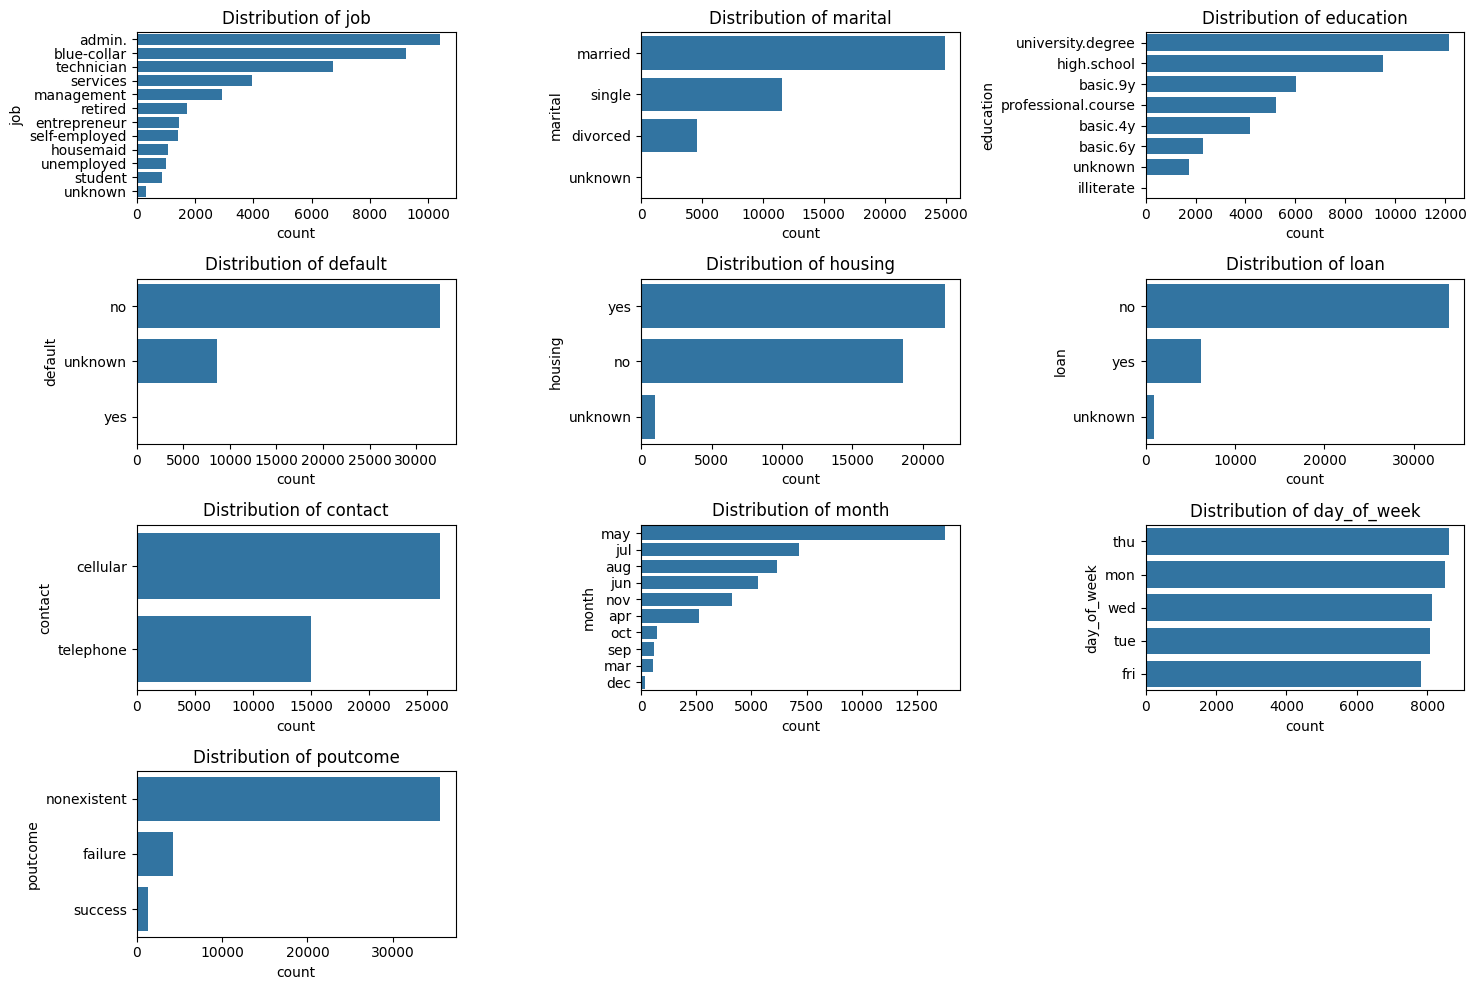

In [66]:
# Visualize categorical feature distribution

plt.figure(figsize=(15, 10))
num_plots = len(categorical_features)
for i, col in enumerate(categorical_features):
    plt.subplot((num_plots + 2) // 3, 3, i + 1)
    sns.countplot(data=df, y=col, order=df[col].value_counts().index)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

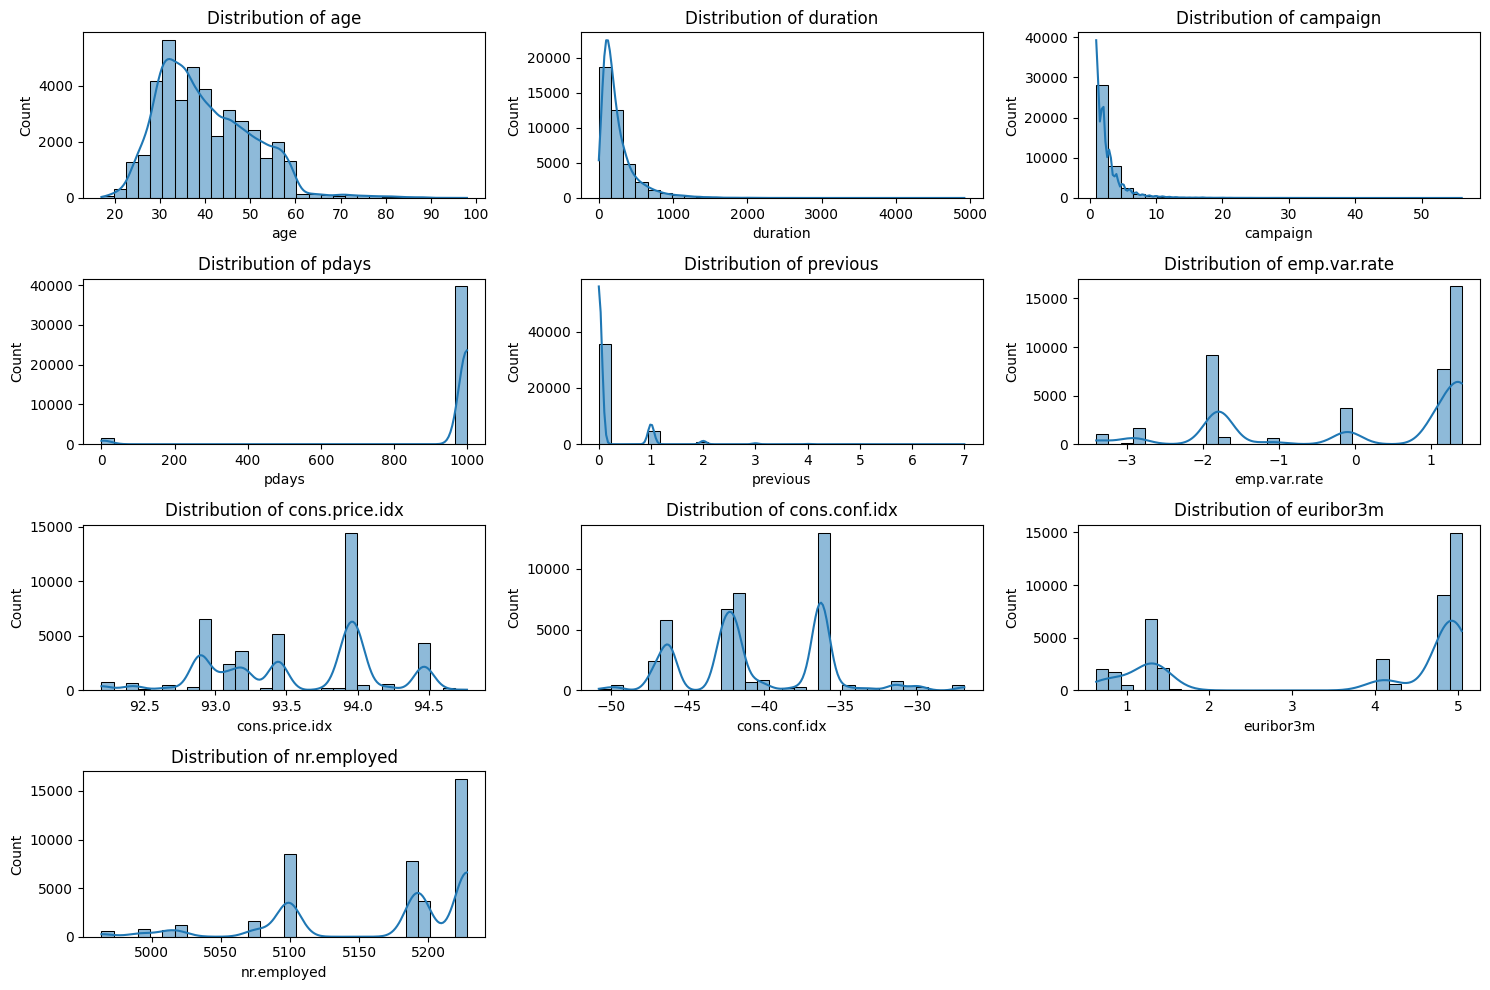

In [67]:
# Visualize numerical feature distribution

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features):
    plt.subplot((len(numerical_features) + 2) // 3, 3, i + 1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

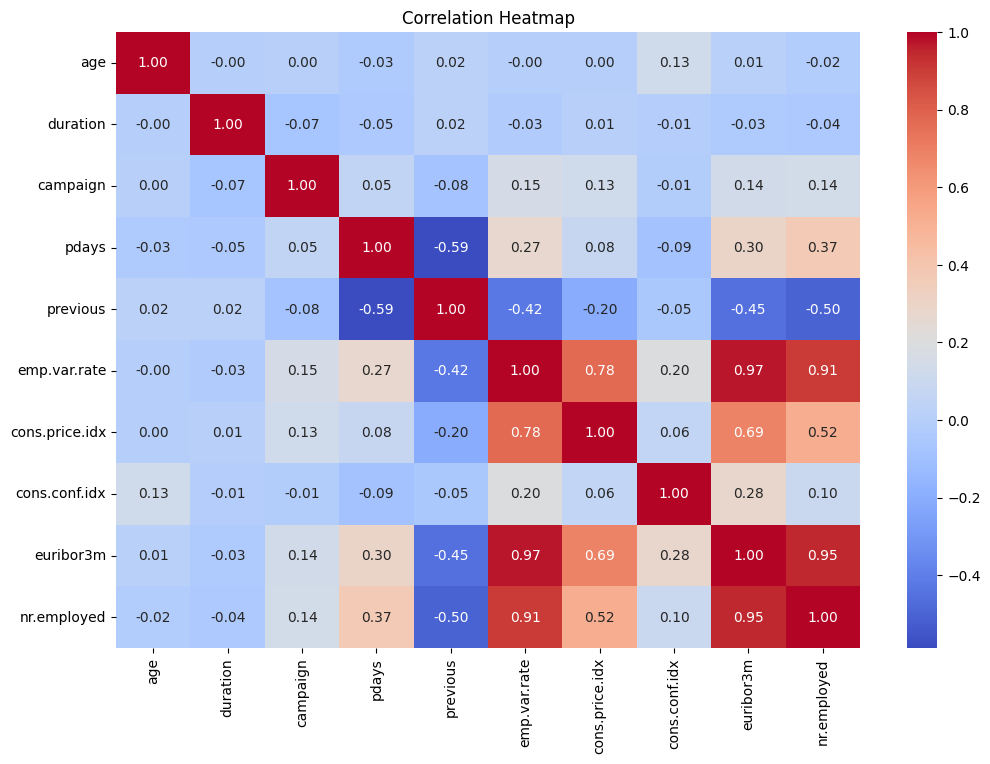

In [68]:
# Correlation heatmap for numerical features

plt.figure(figsize=(12, 8))
correlation_matrix = df[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

## Feature Engineering

In [69]:
# Encode categorical variables

encoded_df = df.copy()
label_encoder = LabelEncoder()
encoded_df['y'] = label_encoder.fit_transform(encoded_df['y'])

In [70]:
# One-hot encode categorical features

encoded_df = pd.get_dummies(encoded_df, columns=categorical_features, drop_first=True)

In [71]:
# Scale numerical features

scaler = StandardScaler()
encoded_df[numerical_features] = scaler.fit_transform(encoded_df[numerical_features])

In [72]:
print("\nEncoded and Scaled Dataset Info:")
encoded_df.info()


Encoded and Scaled Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 54 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41188 non-null  float64
 1   duration                       41188 non-null  float64
 2   campaign                       41188 non-null  float64
 3   pdays                          41188 non-null  float64
 4   previous                       41188 non-null  float64
 5   emp.var.rate                   41188 non-null  float64
 6   cons.price.idx                 41188 non-null  float64
 7   cons.conf.idx                  41188 non-null  float64
 8   euribor3m                      41188 non-null  float64
 9   nr.employed                    41188 non-null  float64
 10  y                              41188 non-null  int64  
 11  job_blue-collar                41188 non-null  bool   
 12  job_entrepre

## Splitting and Balancing Dataset

In [73]:
X = encoded_df.drop(columns=['y'])
y = encoded_df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [74]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("\nResampled Training Set Shape:", X_train_resampled.shape, y_train_resampled.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(



Resampled Training Set Shape: (58490, 53) (58490,)


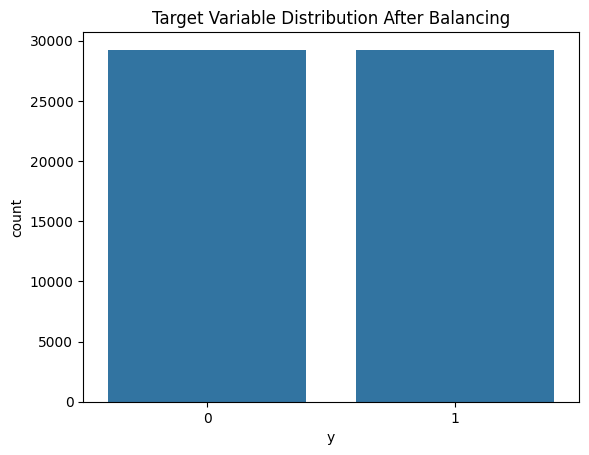

In [75]:
sns.countplot(x=y_train_resampled)
plt.title("Target Variable Distribution After Balancing")
plt.show()

## Random Forest Model with Hyperparameter Tuning

In [76]:
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [10, 15],
    'min_samples_leaf': [4, 6]
}

rf_model = RandomForestClassifier(random_state=42)
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=3, scoring='f1', verbose=2)
rf_grid_search.fit(X_train_resampled, y_train_resampled)
rf_best_model = rf_grid_search.best_estimator_
y_pred_rf = rf_best_model.predict(X_test)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   4.1s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   4.1s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   8.7s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=  11.4s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   8.0s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   9.2s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  13.5s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  13.3s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  13.3s
[CV] END max_depth=1

In [77]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, rf_best_model.predict_proba(X_test)[:, 1])

print("\nRandom Forest Performance:")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")
print(f"ROC-AUC: {roc_auc_rf:.4f}")


Random Forest Performance:
Accuracy: 0.8909
Precision: 0.5121
Recall: 0.8128
F1 Score: 0.6284
ROC-AUC: 0.9422


## Neural Network Model

In [78]:
nn_model = Sequential([
    Dense(256, activation='relu', input_dim=X_train_resampled.shape[1]),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nn_history = nn_model.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=64, validation_split=0.2, verbose=1)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


732/732 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8518 - loss: 0.3350 - val_accuracy: 0.9596 - val_loss: 0.2131
Epoch 2/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8913 - loss: 0.2499 - val_accuracy: 0.9481 - val_loss: 0.2208
Epoch 3/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9017 - loss: 0.2262 - val_accuracy: 0.9485 - val_loss: 0.2147
Epoch 4/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9076 - loss: 0.2173 - val_accuracy: 0.9507 - val_loss: 0.1861
Epoch 5/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9091 - loss: 0.2098 - val_accuracy: 0.9384 - val_loss: 0.2040
Epoch 6/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9121 - loss: 0.2020 - val_accuracy: 0.9588 - val_loss: 0.1627
Epoch 7/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9170 - loss: 0.1947 - val_accuracy: 0.9665 - val_loss: 0.1450
Epoch 8/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9202 - loss: 0.1854 - val_accuracy: 0.9512 - val_

In [79]:
y_pred_nn = (nn_model.predict(X_test) > 0.5).astype('int32')
accuracy_nn = accuracy_score(y_test, y_pred_nn)
precision_nn = precision_score(y_test, y_pred_nn)
recall_nn = recall_score(y_test, y_pred_nn)
f1_nn = f1_score(y_test, y_pred_nn)
roc_auc_nn = roc_auc_score(y_test, nn_model.predict(X_test))

print("\nNeural Network Performance:")
print(f"Accuracy: {accuracy_nn:.4f}")
print(f"Precision: {precision_nn:.4f}")
print(f"Recall: {recall_nn:.4f}")
print(f"F1 Score: {f1_nn:.4f}")
print(f"ROC-AUC: {roc_auc_nn:.4f}")

258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Neural Network Performance:
Accuracy: 0.9002
Precision: 0.5556
Recall: 0.6043
F1 Score: 0.5789
ROC-AUC: 0.9285


## H2O.ai AutoML Benchmark

In [80]:
!pip install h2o

In [81]:
import h2o
from h2o.automl import H2OAutoML

In [82]:
# Initialize H2O

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.25" 2024-10-15; OpenJDK Runtime Environment (build 11.0.25+9-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.25+9-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpyep9tuqp
  JVM stdout: /tmp/tmpyep9tuqp/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpyep9tuqp/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,06 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,1 month and 23 days
H2O_cluster_name:,H2O_from_python_unknownUser_gpngh8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [83]:
# Convert data to H2O Frame

h2o_train = h2o.H2OFrame(pd.concat([X_train_resampled, y_train_resampled], axis=1))
h2o_test = h2o.H2OFrame(pd.concat([X_test, y_test], axis=1))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [84]:
# Define target and predictors

target = 'y'
predictors = X_train.columns.tolist()

In [85]:
# Convert the target column to a categorical type
h2o_train[target] = h2o_train[target].asfactor()
h2o_test[target] = h2o_test[target].asfactor()

# Run AutoML
aml = H2OAutoML(max_runtime_secs=600, seed=42)
aml.train(x=predictors, y=target, training_frame=h2o_train)


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,blending
Number of base models (used / total),3/4
# GBM base models (used / total),1/1
# XGBoost base models (used / total),1/1
# DRF base models (used / total),1/1
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,AUTO
Metalearner nfolds,0
Metalearner fold_column,None


In [86]:
# AutoML Leaderboard

lb = aml.leaderboard
print("\nH2O.ai AutoML Leaderboard:\n", lb.head())


H2O.ai AutoML Leaderboard:
 model_id                                                     auc    logloss     aucpr    mean_per_class_error      rmse        mse
StackedEnsemble_BestOfFamily_2_AutoML_1_20241225_70428  0.994654  0.0945061  0.994958               0.0392524  0.168231  0.0283017
StackedEnsemble_BestOfFamily_3_AutoML_1_20241225_70428  0.994654  0.0945061  0.994958               0.0392524  0.168231  0.0283017
StackedEnsemble_AllModels_1_AutoML_1_20241225_70428     0.994562  0.0950406  0.994857               0.0378008  0.168496  0.028391
StackedEnsemble_AllModels_2_AutoML_1_20241225_70428     0.994562  0.0950406  0.994857               0.0378008  0.168496  0.028391
StackedEnsemble_AllModels_3_AutoML_1_20241225_70428     0.994549  0.0951003  0.994846               0.037627   0.168541  0.0284062
GBM_3_AutoML_1_20241225_70428                           0.993932  0.100898   0.994386               0.0418176  0.17404   0.0302899
GBM_4_AutoML_1_20241225_70428                           

In [87]:
# Predictions and Evaluation

h2o_pred = aml.leader.predict(h2o_test)
accuracy_h2o = (h2o_pred['predict'].as_data_frame().values.flatten() == y_test.values).mean()
print(f"\nH2O.ai AutoML Accuracy: {accuracy_h2o:.4f}")

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%

H2O.ai AutoML Accuracy: 0.9043


/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [88]:
# Shutdown H2O

h2o.shutdown(prompt=False)

H2O session _sid_87c1 closed.


<ipython-input-88-5f2bcab2a40f>:3: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown(prompt=False)


## Model Comparison

In [89]:
model_metrics = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC"],
    "Random Forest": [accuracy_rf, precision_rf, recall_rf, f1_rf, roc_auc_rf],
    "Neural Network": [accuracy_nn, precision_nn, recall_nn, f1_nn, roc_auc_nn],
    "H2O AutoML": [accuracy_h2o, None, None, None, None]
}

comparison_df = pd.DataFrame(model_metrics)

print("\nModel Comparison:")
print(comparison_df)


Model Comparison:
      Metric  Random Forest  Neural Network  H2O AutoML
0   Accuracy       0.890872        0.900218    0.904346
1  Precision       0.512129        0.555556         NaN
2     Recall       0.812834        0.604278         NaN
3   F1 Score       0.628359        0.578893         NaN
4    ROC-AUC       0.942237        0.928515         NaN


## Visualizations

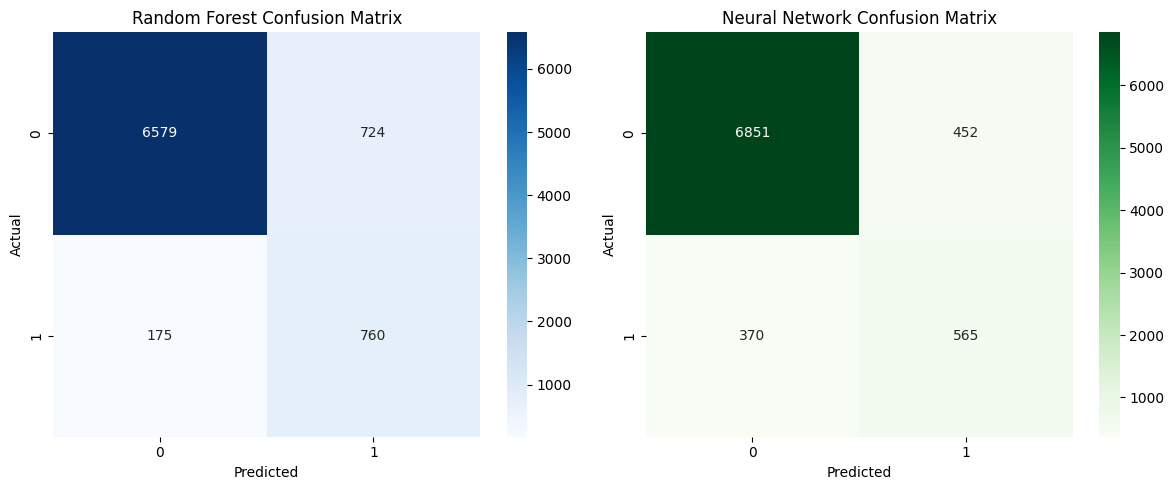

In [90]:
rf_cm = confusion_matrix(y_test, y_pred_rf)
nn_cm = confusion_matrix(y_test, y_pred_nn)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1, 2, 2)
sns.heatmap(nn_cm, annot=True, fmt='d', cmap='Greens')
plt.title("Neural Network Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()

258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


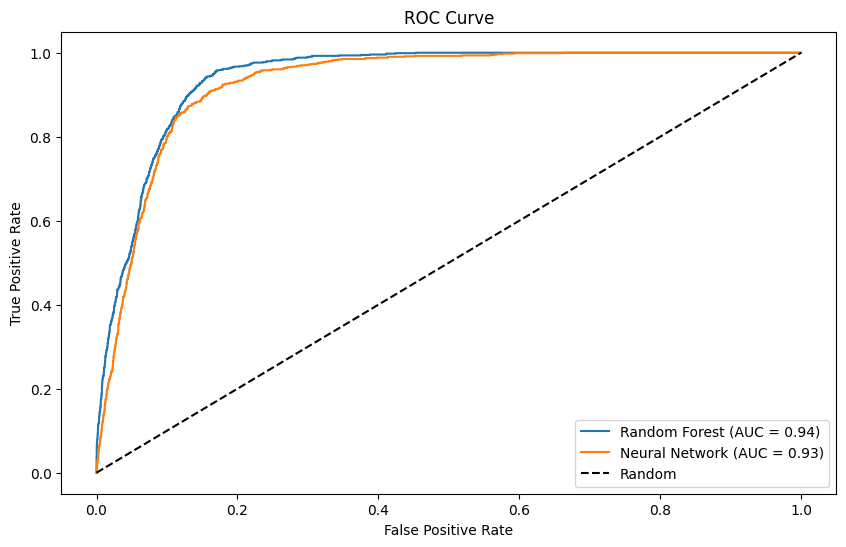

In [91]:
# Plot ROC Curves

rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_best_model.predict_proba(X_test)[:, 1])
nn_fpr, nn_tpr, _ = roc_curve(y_test, nn_model.predict(X_test))

plt.figure(figsize=(10, 6))
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC = {roc_auc_rf:.2f})")
plt.plot(nn_fpr, nn_tpr, label=f"Neural Network (AUC = {roc_auc_nn:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()